# Trying out an LDA model to apply topic modelling to MEAs

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [4]:
# Handle imports
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import pickle
from gensim.models import CoherenceModel
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import pprint
import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm_notebook as tqdm

C:\Users\chave\anaconda3\envs\topicmodelling\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\chave\anaconda3\envs\topicmodelling\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
nlp = spacy.load('en_core_web_lg')
lemmatizer = nlp.get_pipe("lemmatizer")

In [45]:
stop_word_list = [
    "transcript",
    "respondent",
    "ohio",
    "division",
    "department",
    "commerce",
    "financial",
    "revised",
    "code",
    "institutions",
    "chapter",
    "codified",
    "institution",
    "heshe",
    "rc",
    "oh",
    "mortgage",
    "fact",
    "notice",
    "act",
    "chapters",
    "arizona",
    "january",
    "february",
    "april",
    "march",
    "may",
    "june",
    "july",
    "august",
    "september",
    "october",
    "november",
    "december",
    "dfi",
    "ce",
    "pursuant",
    "realize",
    "days",
    "result",
    "investigation",
    "indicate",
    "state",
    "address",
    "appropriate",
    "broker",
    "business",
    "certificate",
    "charge",
    "codify",
    "consistent",
    "date",
    "enforce",
    "find",
    "hearing",
    "mail",
    "mailing",
    "matter",
    "necessary",
    "notify",
    "order",
    "purpose",
    "record",
    "registration",
    "request",
    "responsibility",
    "return",
    "right",
    "serve",
    "loan",
    "officer",
    "application",
    "background",
    "come",
    "attorney",
    "law",
    "duly",
    "appoint",
    "accordance",
    "revise",
    "administrative",
    "detailed",
    "paragraph",
    "page",
    "exhibit",
    "robert",
    "grieser",
    "superintendent",
    "bob",
    "taft",
    "jennifer",
    "protect",
    "proscribe",
    "\\t",
    "m",
    'allege',
    'allegation',
    'appellate',
    'case',
    'authorize',
    'applicant',
    'denial',
    'settlement',
    'agreement',
    'report',
    'recommendation',
    'following',
    'stipulation',
    'admission',
    'finding',
    'findings',
    'basis',
    'administer',
    'amend',
    'amendment',
    'bill',
    'understanding',
    'empower',
    'formal',
    'proceeding',
    'institute',
    'terminate',
    'intent',
    'originate',
    'section',
    'rule',
    'adjucative',
    'hereinafter',
    'motion',
    'jurisdiction',
    'continue',
    'file',
    'opportunity',
    'registrant',
    'conclusion',
    'andor',
    'consideration',
    'wherefore',
    'lieu',
    'specifically',
    'expressly',
    'condition',
    'hearma',
    'damel',
    'broxterman',
    'practice',
    'procedure',
    'time',
    'thereof',
    'attest',
    'tr',
    'p',
    'consider',
    'consist'
]

In [46]:
len(stop_word_list)

154

In [47]:
nlp.Defaults.stop_words.update(stop_word_list)
# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True
lemma_tags = {"NNS", "NNPS"}

In [48]:
# Load data
df = pd.read_csv("Standardized Data/Ohio_Final_cleaned.csv")

In [49]:
def clean_text(sample_text):
    sample_text = sample_text.translate(str.maketrans('', '', string.punctuation))
    sample_text = " ".join([w for w in sample_text.split() if not w.isdigit()])
    sample_text = sample_text.lower()
    doc = nlp(sample_text)
    doc = [token.lemma_ for token in doc if (token.tag_ in lemma_tags or token.lemma_ != '-PRON-' and token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'])]
    doc = u' '.join(doc)
    doc = nlp.make_doc(doc)
    tokens = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return tokens

In [52]:
sample_text = df.loc[4590,"Text"]
print(clean_text(sample_text))
print(len(clean_text(sample_text)))

['accountable', 'licensing', 'individual', 'residential', 'hold', 'license', 'number', 'issue', 'birth', 'employer', 'require', 'suspend', 'prior', 'hear', 'license', 'licensee', 'fail', 'fulfill', 'education', 'requirement', 'require', 'education', 'complete', 'fine', 'dollar', 'pay', 'treasurer', 'credit', 'consumer', 'finance', 'fund', 'c4', 'individual', 'suspend', 'license', 'permit', 'residential', 'hold', 'license', 'calendar', 'year', 'fail', 'fulfill', 'education', 'requirement', 'calendar', 'year', 'license', 'number', 'issue', 'suspend', 'license', 'suspension', 'hear']
54


In [51]:
sample_text

" 5429 Westcastle Drive ) Loan Officer License Suspension Toledo, OH 43615 ) & ) Notice of Appellate Rights ) Respondent, Catherine L. Smith (Respondent), held a Loan Officer License (License) issued by the Division of Financial Institutions (Division) during calendar year 2006. On August 14, 2007, the Division notified Respondent that it issued an Order of License Suspension (Order) because: (1) Respondent failed to comply with the 2006 continuing education requirement set forth in R.C. 1322.052; and (2) because Respondent failed to comply with R.C. 1322.052, the Division is required under R.C. 1322.10(F)(2) to suspend Respondent's License. An administrative hearing was held on September 12, 2007. Respondent failed to appear. A Report and Recommendation (Report) was filed with the Division on September 24, 2007, recommending that the Division continue the suspension of Respondent's License. No objections were filed. In accordance with R.C. 119.09, the Division has considered the recor

In [27]:
from transformers import pipeline
summarizer = pipeline("summarization")
summarizer(sample_text, max_length=200, min_length=30, do_sample=False)

KeyboardInterrupt: 

In [54]:
text = df["Text"]
text_list = []
for doc in tqdm(text):
    if not pd.isna(doc):
        pr = clean_text(doc)
        text_list.append(pr)

C:\Users\chave\anaconda3\envs\topicmodelling\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/6918 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [30]:
# Store word_list in txt file for easier reference

with open('ohio_text_list.txt','w') as file:
    file.writelines("%s\n" % text for text in text_list)

In [31]:
sample_list = []
with open('ohio_text_list.txt','r') as file:
    file_contents = file.readlines()
    for line in file_contents:
        current_text = line[:-1]
        sample_list.append(current_text)

In [33]:
len(sample_list)

6307

In [64]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(text_list, min_count=5, threshold=30) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[text_list], threshold=30) 
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example

print(trigram_mod[bigram_mod[text_list[1]]])

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['charge_responsibility', 'enforce', 'broker', 'codify', 'revise', 'responsibility', 'protect', 'public', 'proscribe', 'practice', 'find', 'order_necessary_appropriate', 'public', 'interest', 'consistent', 'purpose', 'broker', 'send', 'certify_mail', 'intent', 'revoke', 'certificate', 'registration', 'opportunity', 'hear', 'crew', 'funding', 'business', 'address', 'record', 'hold', 'hearing', 'matter', 'accordance', 'daysjuly', 'hearing', 'officer', 'issue', 'report', 'recommendation', 'determine', 'crew', 'funding', 'violate', 'list', 'fictitious', 'creditor', 'false', 'information', 'loan', 'document', 'convert', 'borrower', 'creditor', 'money', 'cause', 'customer', 'sign_blank', 'loan', 'document', 'charge', 'excess', 'fee', 'interfere', 'crew', 'funding', 'order', 'page', 'hearing', 'officer', 'report', 'recommend', 'superintendent', 'revoke', 'broker', 'certificate', 'registration', 'file', 'objection', 'hearing', 'officer', 'report', 'recommendation', 'carefully', 'consider', 'he

In [65]:
grammed_list = [trigram_mod[bigram_mod[doc]]for doc in text_list]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(text_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in text_list]

In [67]:
# Creates, which is a mapping of word IDs to words.
grammed_words = corpora.Dictionary(grammed_list)

# Turns each document into a bag of words.
grammed_corpus = [words.doc2bow(doc) for doc in grammed_list]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=words, random_state = 12)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [40]:
model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=19, id2word=words, random_state = 12)

In [41]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=words, corpus=corpus, texts=text_list, start=18, limit=25, step=1)

In [134]:
# Can take a long time to run.
grammed_model_list, grammed_coherence_values = compute_coherence_values(dictionary=grammed_words, corpus=grammed_corpus, texts=grammed_list, start=18, limit=25, step=1)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
import tomotopy as tp
import numpy as np

term_weight = tp.TermWeight.ONE
hdp = tp.HDPModel(tw = term_weight, min_cf =5, rm_top = 7, gamma = 1, alpha = 0.1,initial_k = 10, seed = 12)

In [38]:
sum = 0
for text in text_list:
    if len(text) > 0:
        hdp.add_doc(text)
print(sum)
# Initiate sampling burn-in  (i.e. discard N first iterations)
hdp.burn_in = 100
hdp.train(0)
print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs,
      ', Num words:', hdp.num_words)
print('Removed top words:', hdp.removed_top_words)

# Train model
for i in range(0, 1000, 100):
    hdp.train(100) # 100 iterations at a time
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))

0
Num docs: 6307 , Vocab size: 3075 , Num words: 711371
Removed top words: ['license', 'fail', 'agreement', 'applicant', 'deny', 'settlement', 'require']
Iteration: 0	Log-likelihood: -5.5123050165948655	Num. of topics: 20
Iteration: 100	Log-likelihood: -5.4955127267725405	Num. of topics: 21
Iteration: 200	Log-likelihood: -5.492154133615611	Num. of topics: 21
Iteration: 300	Log-likelihood: -5.490310820734719	Num. of topics: 22
Iteration: 400	Log-likelihood: -5.490012325040066	Num. of topics: 21
Iteration: 500	Log-likelihood: -5.489481220700889	Num. of topics: 21
Iteration: 600	Log-likelihood: -5.489107288511624	Num. of topics: 22
Iteration: 700	Log-likelihood: -5.489021376904994	Num. of topics: 21
Iteration: 800	Log-likelihood: -5.488699733876569	Num. of topics: 21
Iteration: 900	Log-likelihood: -5.488527247577251	Num. of topics: 21


In [87]:
model = model_list[4].save("lda.model")
model2= gensim.models.ldamodel.LdaModel.load("lda.model")

In [131]:
term_weight = tp.TermWeight.ONE
hdp_gram = tp.HDPModel(tw = term_weight, min_cf =5, rm_top = 7, gamma = 1, alpha = 0.1,initial_k = 10, seed = 12)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [132]:
sum = 0
for text in grammed_list:
    if len(text) > 0:
        hdp_gram.add_doc(text)
print(sum)
# Initiate sampling burn-in  (i.e. discard N first iterations)
hdp_gram.burn_in = 100
hdp_gram.train(0)
print('Num docs:', len(hdp_gram.docs), ', Vocab size:', hdp_gram.num_vocabs,
      ', Num words:', hdp_gram.num_words)
print('Removed top words:', hdp_gram.removed_top_words)

# Train model
for i in range(0, 1000, 100):
    hdp_gram.train(100) # 100 iterations at a time
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp_gram.ll_per_word, hdp_gram.live_k))

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
Num docs: 5596 , Vocab size: 3609 , Num words: 525801
Removed top words: ['loan', 'officer', 'license', 'application', 'hearing', 'fail', 'deny']
Iteration: 0	Log-likelihood: -5.440105475753123	Num. of topics: 23
Iteration: 100	Log-likelihood: -5.43156534654541	Num. of topics: 23
Iteration: 200	Log-likelihood: -5.427888941099954	Num. of topics: 23
Iteration: 300	Log-likelihood: -5.426786755578517	Num. of topics: 25
Iteration: 400	Log-likelihood: -5.427086953384736	Num. of topics: 24
Iteration: 500	Log-likelihood: -5.425923427824316	Num. of topics: 25
Iteration: 600	Log-likelihood: -5.426840598779457	Num. of topics: 24
Iteration: 700	Log-likelihood: -5.426455026874063	Num. of topics: 24
Iteration: 800	Log-likelihood: -5.4272274290496405	Num. of topics: 25
Iteration: 900	Log-likelihood: -5.4266974182563805	Num. of topics: 24


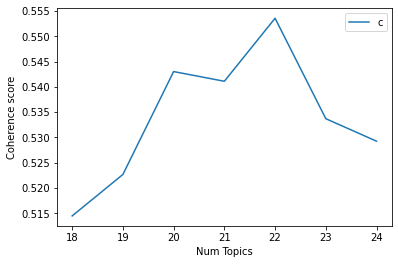

In [42]:
# Show graph
limit=25; start=18; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [43]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 18  has Coherence Value of 0.5145
Num Topics = 19  has Coherence Value of 0.5227
Num Topics = 20  has Coherence Value of 0.543
Num Topics = 21  has Coherence Value of 0.5411
Num Topics = 22  has Coherence Value of 0.5536
Num Topics = 23  has Coherence Value of 0.5337
Num Topics = 24  has Coherence Value of 0.5293


/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


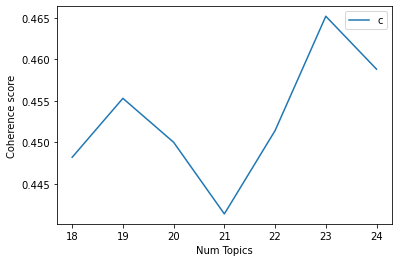

In [137]:
# Show graph
limit=25; start=18; step=1;
x = range(start, limit, step)
plt.plot(x, grammed_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [138]:
# Print the coherence scores
for m, cv in zip(x, grammed_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 18  has Coherence Value of 0.4482
Num Topics = 19  has Coherence Value of 0.4553
Num Topics = 20  has Coherence Value of 0.45
Num Topics = 21  has Coherence Value of 0.4414
Num Topics = 22  has Coherence Value of 0.4514
Num Topics = 23  has Coherence Value of 0.4652
Num Topics = 24  has Coherence Value of 0.4588


/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
gensimvis.prepare(model_list[4], corpus, words)

NameError: name 'model_list' is not defined

In [53]:
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [70]:
def format_topics_sentences(ldamodel=model_list[4], corpus=corpus, texts=text_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model_list[4], corpus=corpus, texts=text_list)

In [77]:
df_topic_sents_keywords["Dominant_Topic"] = df_topic_sents_keywords["Dominant_Topic"].apply(lambda x: mapping[x])

In [1]:
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==18]

NameError: name 'df_dominant_topic' is not defined

In [73]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,16.0,0.3618,"suspension, license, tr, uniform, testimony, hold, appear, court, receive, question","[conduct, affair, allege, follow, incorporator, statutory, agent, president, joint, action, cause, customer, proceed, excess, disburse, mean, fictitious, creditor, customer, relate, document, joint, action, cause, customer, proceed, excess, intend, customer, legitimate, creditor, customer, convert, knowledge, improper, fraudulent, dishonest, practice, fail, implement, review, control, measure, design, prevent, future, improper, fraudulent, dishonest, practice, joint, action, fail, disclose, fee, violation, federal, real, estate, settlement, procedure, joint, action, receive, customer, proceed, disbursement, fictitious, creditor, disbursement, constitute, receipt, unearned, fee, thing, value, violation, federal, real, estate, settlement, procedure, joint, action, devise, intend, devise, scheme, artifice, defraud, obtain, money, mean, false, fraudulent, pretense, representation, transmit, cause, transmit, ...]"
1,1,17.0,0.3324,"license, originate, violation, residential, violate, conduct, examination, document, fine, registrant","[abovecaptione, license, practice, procedure, commence, office, south, high, floor, hold, close, day, hold, follow, funding, hereinafter, crew, consider, intent, revoke, inter, alia, base, engage, improper, fraudulent, dishonest, activity, appear, hereinafter, represent, general, general, appear, represent, jurisdiction, issue, intent, deny, opportunity, hereinafter, refer, case, 01mb11, service, perfect, timely, schedule, requirement, orc, continue, original, counsel, continue, new, counsel, continue, forward, posthearing, ruling, offer, remain, rule, 3h, letter, apparently, sign, crew, letterhead, letter, white, testimony, p, testimony, letter, examination, additional, testimony, include, testimony, opposition, offer, leave, determine, admission, admit, use, weight, document, 3h, appear, belong, witness, appear, similarity, likely, obtain, document, simply, filing, ...]"
2,2,7.0,0.4104,"report, license, recommendation, file, appellate, deny, objection, issue, recommend, hold","[public, practice, public, interest, send, certify, intent, revoke, opportunity, hear, crew, funding, hold, daysjuly, issue, report, recommendation, determine, crew, funding, violate, list, fictitious, creditor, false, information, document, convert, borrower, creditor, money, cause, customer, sign, blank, document, excess, fee, interfere, crew, funding, report, recommend, revoke, file, objection, report, recommendation, carefully, consider, report, recommendation, objection, thereto, reject, objection, confirm, approve, report, recommendation, previously, issue, crew, funding, revoke]"
3,3,14.0,0.4220,"renewal, license, intent, refuse, issue, deny, terminate, renew, termination, requirement","[send, services, corporation, certify, intent, deny, receive, inform, intention, issue, deny, base, determination, fail, provide, information, conclude, meet, education, experience, requirement, response, time, expire, recently, contact, secretary, vice, president, inform, long, operate, receive, fax, issue, withdraw, intention, issue, deny, moot, accordingly, terminate, services, corporation, termination, hear]"
4,4,3.0,0.4314,"license, issue, fail, day, appellate, allegation, deny, refuse, inform, renewal","[public, lending, practice, interest, public, specialists, corporation, renew, period, certify, intent, revoke, entitle, adjudicative, day, day, issue, revoke, specialists, specialists, fail, fail, defend, allegation, violate, substantial, misrepresentation, renewal, obtain, false, fraudulent, representation, allegation, contain, true, revoke]"
...,...,...,...,...,...
6302,6302,19.0,0.6882,"applicant, agreement, agree, settlement, violation, understand, condition, apply, omba, requirement","[settlement, agreement, enter, basis, following, stipulation, admission, understandi

In [80]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1,0.9841,"license, year, calendar, fail, require, refuse, comply, complete, hour, authorize","[conduct, follow, authorize, refuse, renew, license, licensee, applicant, violate, fail, comply, provision, section, rule, adopt, section, applicable, conduct, b, previously, hold, license, calendar, year, require, licensed, complete, hour, approve, continue, education, calendar, year, 31st, fail, complete, require, hour, credit, calendar, year, require, e, fail, comply, authorize, refuse, renew, license, park, opportunity, case, suspend, license, license, suspend, meet, condition, renewal]"
1,2,0.9888,"license, issue, fail, day, appellate, allegation, deny, refuse, inform, renewal","[silverleaf, drive, denial, renewal, appellate, administer, interest, public, issue, m, fast, license, license, expire, file, renew, license, renewal, remain, pende, issue, inform, conduct, thereof, allege, fail, comply, complete, hour, continue, education, calendar, year, fail, comply, authorize, refuse, renew, license, informed, intent, deny, license, renewal, opportunity, regard, denial, day, far, caution, receive, write, office, day, time, issue, deny, renewal, license, unable, obtain, service, provide, publish, consecutive, week, m, fast, appellate, fail, statutory, deadline, fail, defend, allegation, allegation, contain, true, license, renewal, deny, fast, license, renewal, deny]"
2,3,0.9974,"list, action, license, violate, statement, applicant, prohibit, criminal, conduct, provide","[conduct, follow, convict, unauthorized, use, property, misdemeanor, fourth, degree, case, crb, court, common, pleas, plead, guilty, convict, attempt, receive, steal, property, misdemeanor, degree, case, cr, c, convict, theft, misdemeanor, degree, case, crb, plead, guilty, convict, operate, motor, vehicle, intoxicate, case, trc, e, plead, guilty, convict, operate, motor, vehicle, intoxicate, misdemeanor, degree, case, intent, deny, license, opportunity, hear, plead, guilty, convict, operate, motor, vehicle, intoxicate, misdemeanor, degree, case, trc, plead, guilty, convict, assault, misdemeanor, degree, case, crb, h, attest, swear, statement, information, provide, criminal, license, submit, complete, truthful, attempt, obtain, license, provide, untruthful, information, criminal, finding, list, determine, action, list, prove, ...]"
3,4,0.9894,"report, license, recommendation, file, appellate, deny, objection, issue, recommend, hold","[denial, license, submit, license, issue, intent, deny, thereto, hold, file, write, report, recommendation, recommend, deny, copy, report, recommendation, letter, explain, submit, written, objection, report, certify, objection, file, consideration, report, recommendation, objection, thereto, evidence, admit, modify, certain, report, recommendation, follow, report, recommendation, specifically, approve, modify, report, recommendation, include, trotter, felony, conviction, separate, reason, cite, support, position, trotter, grant, license, modify, report, recommendation, strike, reference, withdrawal, trotter, mention, withdraw, want, cancel, inform, trotter, present, need, submit, sentence, modify, read, indication, attempt, continue, modification, andor, disapproval, approve, finding, recommendation, accordingly, license, deny]"
4,5,0.9327,"applicant, agreement, agree, settlement, violation, understand, condition, apply, omba, requirement","[settlement, agreement, enter, basis, following, stipulation, admission, understanding, empower, issue, applicant, license, thing, applicant, comply, section, require, complete, hour, approve, continue, education, calendar, year, 31st, hold, license, calendar, year, d, admit, fail, complete, require, credit, hour, calendar, year, e, fail, comply, authority, refuse, issue, enter, settlement, agreement, lieu, formal, proceeding, deny, license, basis, admit, violation, noncompliance, expressly, reserve, institute, formal, proceeding, base, violation, noncomplianc

In [75]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts.head()
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Num_Documents,Perc_Documents
0.0,881,0.1397
3.0,811,0.1286
10.0,666,0.1056
7.0,611,0.0969
19.0,568,0.0901
13.0,433,0.0687
14.0,348,0.0552
8.0,335,0.0531
17.0,310,0.0492
16.0,273,0.0433


In [76]:
df_dominant_topics.sort_values(by = ["Num_Documents"],ascending = False, inplace = True)
df_dominant_topics["Old Index"] = df_dominant_topics.index 
df_dominant_topics.reset_index(inplace = True)
mapping = df_dominant_topics[["Old Index"]].to_dict()['Old Index']
mapping = {value : key+1 for (key, value) in mapping.items()}
mapping

{0.0: 1,
 3.0: 2,
 10.0: 3,
 7.0: 4,
 19.0: 5,
 13.0: 6,
 14.0: 7,
 8.0: 8,
 17.0: 9,
 16.0: 10,
 21.0: 11,
 1.0: 12,
 12.0: 13,
 4.0: 14,
 18.0: 15,
 6.0: 16,
 2.0: 17,
 20.0: 18,
 9.0: 19,
 15.0: 20,
 11.0: 21}